# Notebook 4: Deterministic Finite Automata

In [1]:
#@title Setup
!pip install -qqq tock
from tock import *
!test -x /content/theory || git clone --quiet https://github.com/ND-CSE-30151/spring-2025 /content/theory
%cd -q /content/theory/notes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 537.0/537.0 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


<div class="alert alert-info">
    <p><b>Read</b> 1.1.</p>
</div>

In the first class, I said that we would study a sequence of kinds of "computers" leading up to Turing machines. Today we'll look at the simplest of these, finite automata, which are only allowed to make a single left-to-right pass through the input.

- The machine is fed an input string.
- At each time step, it reads one symbol and moves one symbol to the right.
- It has only a finite number of states (another way of saying this: it uses only $O(1)$ memory).
- When it reaches the end of the string, it decides whether to accept or reject the string.

Sipser uses an automatic door to illustrate a finite automaton. (The door is the type that swings open toward the rear, not the type that slides open.) This example is good because its state is something visible. But this automaton doesn't have accept states, because the input string has no end and the automaton's job is not to accept or reject strings. So the door is best thought of as an analogy more than a strict example.

## DFAs by example

Let's look at an example DFA, the book's $M_1$. In lecture notes I'll be using a toolkit called [Tock], which displays and runs automata inside Jupyter notebooks. You are welcome to use it to tinker with automata or to write your homework assignments.

[Tock]: https://github.com/ND-CSE-30151/tock

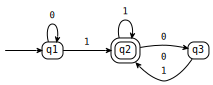

In [ ]:
m1 = read_csv('dfa-m1.csv')
m1

Viewed this way, the nodes are _states_ and the edges are _transitions_. At any given time, the DFA is "in" one of its states. It starts in the _start_ state $q_1$, indicated by the arrow from nowhere. It reads in a string (say, `1101`), and for each symbol, it follows the transition labeled with that symbol. When it reaches the end of the string, if it is in an _accept_ state (indicated by the double circle, which is supposed to look like a bullseye), it accepts the string. Otherwise, it rejects the string. We can visualize this like so:

In [ ]:
run(m1, "1 1 0 1").only_path()

q1,[1] 1 0 1
q2,[1] 0 1
q2,[0] 1
q3,1
q2,ε


Each row is a step of the computation. The first column shows the state, and the second column shows the remaining input (with the next symbol to be read in square brackets). At the last step, the machine is in state $q_2$, and there is no more input ($\varepsilon$). Since $q_2$ is an accept state, the machine accepts the string.

Contrast this with the following run:

In [ ]:
run(m1, "1 0 1 0 0 0").only_path()

q1,[1] 0 1 0 0 0
q2,[0] 1 0 0 0
q3,[1] 0 0 0
q2,[0] 0 0
q3,[0] 0
q2,0
q3,ε


This time, the machine ended up in state $q_3$, which is not an accept state, so the automaton rejected the string.

If $M$ is a DFA, the language of all strings that $M$ accepts is called the language *recognized* by $M$ and is written $\mathcal{L}(M)$.

The "deterministic" in "deterministic finite automaton" means that for every state $q$ and for every symbol $a$, there is exactly one transition out of $q$ on $a$. Thus, at every time step, the automaton always knows which state to go to.

Here are the other example DFAs from the book if you want to try them out:

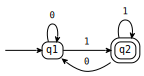

In [ ]:
m2 = read_csv('dfa-m2.csv')
m2

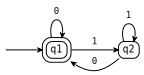

In [ ]:
m3 = read_csv('dfa-m3.csv')
m3

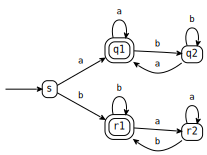

In [ ]:
m4 = read_csv('dfa-m4.csv')
m4

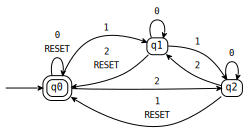

In [ ]:
m5 = read_csv('dfa-m5.csv')
m5

**Exercise.** Imagine you're implementing a programming language that only uses the symbols $\{\texttt{a}, \texttt{1}\}$.

a. As in many other programming languages, a variable name can contain digits but must start with a letter. Write a DFA that accepts only variable names.

b. Our programming language has one reserved word, $\texttt{aa}$. Write a DFA that accepts anything *but* $\texttt{aa}$.

A common shorthand is to relax the definition of determinism so that for every state $q$ and symbol $a$, there is *at most* one transition out of $q$ on $a$. Then if the automaton is in state $q$ and the next symbol is $a$ and there is no transition out of $q$ on $a$, the automaton immediately rejects.

This doesn't make DFAs any more powerful, because if $q$ doesn't have an outgoing transition on $a$, we can think of it as shorthand for an implicit transition from $q$ on $a$ to a *dead state* (a non-accept state whose outgoing transitions all go back to itself).

## Formal definition

To write proofs about DFAs, we need a formal definition both of DFAs and how they work. As we'll use the definition of DFA a lot more, I'll go over that here.

A DFA is a tuple $(Q, \Sigma, \delta, s, F)$. All of the automata and grammars we define are going to be tuples. (If we were programming, we would use a `class` or `struct`, but math only gives us tuples.)

- $Q$ is a finite set of *states*. See [A note on the letter *q*](#A-note-on-the-letter-q) for the notation we use for states.
- $\Sigma$ is a finite alphabet.
- $s \in Q$ is the *start* state (also called the *initial* state).
- $F \subseteq Q$ is the set of *accept* states (also called *final* states).
- $\delta : Q \times \Sigma \rightarrow Q$ (this notation means that $\delta$ is a function that takes two arguments, a state and a symbol, and returns a state) is the *transition function*.

For example, look at $M_2$ again:

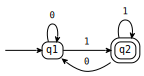

In [ ]:
m2

We could have written this more formally as

\begin{align}
M_2 &= (\{q_1, q_2\}, \{\texttt{0}, \texttt{1}\}, \delta, q_1, \{ q_2 \} ) \\
\delta(q_1, \texttt{0}) &= q_1 \\
\delta(q_1, \texttt{1}) &= q_2 \\
\delta(q_2, \texttt{0}) &= q_1 \\
\delta(q_2, \texttt{1}) &= q_2.
\end{align}

But whenever I ask you to write a DFA, it is always okay to draw a picture instead of writing it like this.

## Complementation

As an example of why the formal definition is useful, let's prove that if a language $L$ is regular, then $\overline{L}$ is also regular. (More explicitly: If $L$ is a language over $\Sigma$, then $\overline{L} = \Sigma^\ast \setminus L$ is also regular.)

A more intuitive proof would go like this:

> Given a DFA $M$ recognizing $L$, we can construct a DFA $\overline{M}$ by changing all the accept states into non-accept states, and all the (original) non-accept states into accept states. Then $\overline{M}$ recognizes $\overline{L}$; we omit a proof of correctness.

But this proof leaves some things uncertain. First, it's written in an "imperative" style that can become difficult to follow for more complex constructions: after changing all the accept states into non-accept states, all the states are non-accept states, so in the second step, should I change all the states into accept states? The word "(original)" is supposed to clarify, but it's not great. Second, if we use the "implicit dead state" shorthand described above, then following these instructions literally will give an incorrect result.

So a construction based on the formal definition will be more precise. It goes like this:

> Given a DFA $M = (Q, \Sigma, \delta, s, F)$ recognizing $L$, we can construct a DFA $\overline{M} = (Q, \Sigma, \delta, s, Q \setminus F)$. Then $\overline{M}$ recognizes $\overline{L}$; we omit a proof of correctness.

In proofs that involve constructions like this one, it's usually pretty clear that the construction works, and I'm usually okay with you omitting the proof of correctness. If you wanted to add one, it would go like this.

> Then $\overline{M}$ recognizes $\overline{L}$. For if $w \in L$, then $M$, after reading $w$, is in state $q$, which is in $F$, so $\overline{M}$, after reading $w$, is also in state $q$, which is not in $Q \setminus F$, so $\overline{M}$ rejects $w$. On the other hand, if $w \not\in L$, then $M$, after reading $w$, is in state $q$, which is not in $F$, so $\overline{M}$, after reading $w$, is also in state $q$, which is in $Q \setminus F$, so $\overline{M}$ accepts $w$.

## The product construction

Sipser's section "The regular operations" is slightly unusual. These closure properties are important, and where he's going with this is that these closure properties will be used to prove that any regular expression can be compiled into a finite automaton. But using DFAs, this proof is not easy and he gives up halfway. Sipser uses this as a motivation for nondeterminism, which is introduced in the next section. The proof of both Theorem 1.25 and 1.26 will turn out to be very easy.

On the other hand, the proof of Theorem 1.25 has a footnote (3) regarding closure under intersection. This is an important result and the Cartesian product construction *is* the standard way to prove it. I think it deserves more than a footnote, so let's take a closer look at it.

We're given two DFAs, call them $M_A$ and $M_B$, and we want to build a DFA $M$ that recognizes the language $L(M_A) \cap L(M_B)$. That is, $M$ should accept a string if and only if $M_A$ accepts it *and* $M_B$ accepts it.

### By example

Consider the following two DFAs, called $M_A$ and $M_B$. They both accept strings of 1's; $M_A$ accepts the string iff the length is a multiple of 2, and $M_B$ accepts the string iff the length is *not* a multiple of 3.

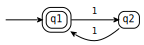

In [ ]:
ma = read_csv('dfa-ma.csv')
ma

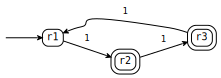

In [ ]:
mb = read_csv('dfa-mb.csv')
mb

Their intersection looks like this; it accepts a string iff the length is a multiple of 2 but *not* a multiple of 3.

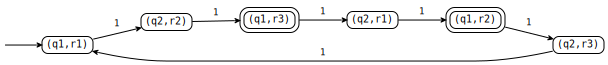

In [ ]:
intersect(ma, mb)

Let's see how to build $M$ step by step. Apologies that the following examples are not editable. The basic idea is that $M$ has to simulate what $M_A$ would do and what $M_B$ would do, both at the same time. So the states of $M$ are pairs $(q, r)$, where $q$ is the simulated state of $M_A$ and $r$ is the simulated state of $M_B$. I like to arrange the states in a grid, like this:

![image](https://raw.githubusercontent.com/ND-CSE-30151/spring-2025/refs/heads/main/notes/mab0.svg)

The start state of $M$ is $q_1r_1$, which comes from the start state of $M_A$ and the start state of $M_B$. And the accept states are $q_1r_2$ and $q_1r_3$, which come from the accept states of $M_A$ and the accept states of $M_B$.

If $M$ is in the start state and it reads `1`, then $M_A$ would transition to state $q_2$, and $M_B$ would transition to state $r_2$. So $M$ should transition to state $q_2r_2$:

![image](https://raw.githubusercontent.com/ND-CSE-30151/spring-2025/refs/heads/main/notes/mab1.svg)

From state $q_2r_2$, on symbol `1`, $M_A$ would transition to state $q_3$ and $M_B$ would transition to state $r_1$, so $M$ should transition to $q_1r_3$:

![image](https://raw.githubusercontent.com/ND-CSE-30151/spring-2025/refs/heads/main/notes/mab2.svg)

Repeat for all states and all symbols to get the following end result (which is the same as what Tock computed):

![image](https://raw.githubusercontent.com/ND-CSE-30151/spring-2025/refs/heads/main/notes/mab.svg)

**Exercise.** Combine the starts-with-letter DFA and the no-reserved-word DFA into a single DFA.

### General proof

If you had to write the product construction for homework, the above example wouldn't be sufficient. So let's write this as a general construction.

Theorem. If $A$ and $B$ are regular languages, then $A \cap B$ is also regular.

Proof. Since $A$ and $B$ are regular, they are recognized by DFAs
\begin{align}
M_A &= (Q_A, \Sigma, \delta_A, s_A, F_A) \\
M_B &= (Q_B, \Sigma, \delta_B, s_B, F_B).
\end{align}
We construct a DFA $M$ that recognizes $A \cap B$ as follows.

Each state of $M$ is of the form $(q, r)$, where $q \in Q_A$ and $r \in Q_B$. The start state is $(s_A, s_B)$.

For every transition in $M_A$ that goes from state $q_1$ on symbol $a$ to state $q_2$, and for every transition in $M_B$ that goes from state $r_1$ on symbol $a$ to state $r_2$, create a transition in $M$ that goes from state $(q_1, r_1)$ on symbol $a$ to state $(q_2, r_2)$.

A state $(q,r)$ is accepting if $q \in F_A$ and $r \in F_B$.

Alternatively, we could construct $M$ more formally and concisely as:
\begin{align}
M &= (Q_A \times Q_B, \Sigma, \delta, (s_A, s_B), F_A \times F_B) \\
\delta((q, r), a) &= (\delta_A(q, a), \delta_B(r, a)).
\end{align}

We omit a proof of correctness. But if you want to see what one would look like, expand the cell below.

#### Proof of correctness

To reduce clutter, introduce the notation $M(w) = q$, for any DFA $M$, string $w$, and state $q$ of $M$, to mean "$M$, after reading $w$, is in $q$".

Claim 1: For any string $w$, $M(w) = (M_A(w),M_B(w))$.

Proof of Claim 1: By induction on the length of $w$.

The base case ($w = \varepsilon$) is true because $M(\varepsilon) = (s_A, s_B) = (M_A(\varepsilon), M_B(\varepsilon))$.

For the inductive step, assume that $M(w) = (M_A(w),M_B(w))$ and let $a$ be a symbol. Then
\begin{align}
M(wa) &= \delta(M(w), a) \\
&= \delta((M_A(w), M_B(w)), a) \\
&= (\delta_A(M_A(w),a), \delta_B(M_B(w),a)) \\
&= (M_A(wa), M_B(wa)).
\end{align}

Now, to prove the correctness of the product construction, observe that if $w \in A \cap B$, then $M_A(w) \in F_A$ and $M_B(w) \in F_B$, so $M(w) = (M_A(w), M_B(w)) \in F_A \times F_B$. Similarly, if $w \not\in A\cap B$, then $M(w) \not\in F_A \times F_B$.

<a name="A-note-on-the-letter-q"></a>
## A note on the letter _q_

We use the letter $q$ to stand for states. This usage goes back at least to Turing; I'm guessing that it may come from physics, where it stands for a "generalized coordinate." But more importantly, there's some fuzziness in the way that this letter is used that I need to call attention to.

With alphabet symbols, the book makes a careful distinction between `a`, a particular symbol, and $a$, a variable standing for a symbol.

With states, the book is not so careful. Particular states are almost always given names $q_1, q_2,$ etc., and occasionally $q_0$ or $q_{\text{whatever}}$ or $r_1, r_2,$ etc., or other names. Variables ranging over states are usually named $q$ or $r$, but not infrequently $q_1, q_2$, etc.

To make this distinction more clear, consider the two statements:

1. In DFA $M_2$ above, $q_1 = q_2$.
2. Let $q_1$ and $q_2$ be states such that there is a transition from $q_1$ to $q_2$ on symbol `a`.

The first statement is false. $q_1$ and $q_2$ refer to particular states, and they are different states.

In the second statement, $q_1$ and $q_2$ are variables ranging over states. Here, it is completely possible for $q_1=q_2$.

This is confusing to be sure. I'll try to use the following conventions, different from the book:

- We'll write $q_1, q_2$, etc. for particular states.
- We'll use $s$ (not $q_0$) for the variable that stands for the start state (i.e., a DFA is a tuple $(Q, \Sigma, \delta, s, F)$).
- We'll use $q$ and $r$ as variables that stand for states.
- We may also (rarely) use $q_i, q_j, q_k$ to stand for states. Technically, this means that we have assigned names $q_1, q_2, \ldots$ to the states, and are using variables $i, j, k$ to stand for state indices.